# Association Analysis
This notebook contains work done for association analysis on the Mozambique
dataset from IPUMS.

# Loading Data and Dependancies

In [ ]:
# Load Dependencies
from pathlib import Path
import pandas as pd
import numpy as np
from efficient_apriori import apriori # https://pypi.org/project/efficient-apriori/
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load Custom Scripts
from src.utils.ipums_extract import (
    load_ipums_from_pkl,
)

PKL_PATH = Path(r"data/mozambique.pkl")

In [ ]:
# Load data from PKL
mig1_df, mig5_df = load_ipums_from_pkl(PKL_PATH)

print(mig1_df.shape)
print(mig5_df.shape)

(5929529, 66)
(4974569, 66)


# Creating Training & Test Set 

Data is splitted into training, test sets, additionally the data is filtered on records where migration occured to generate itemsets as. Full dataset are kept and will be used for testing.

In [3]:
# Split data
SEED = 5523
CV_RATIO = 0.20
VAL_RATIO = 0.15
TEST_RATIO = 0.15
TRAIN_RATIO = 1 - VAL_RATIO - TEST_RATIO

# Create Development Splits (Train/Val/Test)

# Split the data set
df1_train, df1_test = train_test_split(mig1_df, test_size=TEST_RATIO, random_state=SEED) 
df1_train, df1_val = train_test_split(mig1_df, test_size=VAL_RATIO/(1-TEST_RATIO), random_state=SEED)

df5_train, df5_test = train_test_split(mig5_df, test_size=TEST_RATIO, random_state=SEED) 
df5_train, df5_val = train_test_split(mig5_df, test_size=VAL_RATIO/(1-TEST_RATIO), random_state=SEED)

In [28]:
# Only use records where migration is 1 for itemset building, bring back others when calculating rule metrics
df1_train_filtered = df1_train[df1_train['MIGRATE1'] == 1].drop('MIGRATE1', axis=1).copy()
df5_train_filtered = df5_train[df5_train['MIGRATE5'] == 1].drop('MIGRATE5', axis=1).copy()

print(df1_train_filtered.shape)
print(df5_train_filtered.shape)

(56721, 65)
(187536, 65)


In [12]:
# For the data as nested list of strings for apriori algorithm
transactions1 = []
for index, row in df1_train_filtered.iterrows():
    transaction_items = tuple(row.index[row == 1].tolist())
    transactions1.append(transaction_items)

transactions5 = []
for index, row in df5_train_filtered.iterrows():
    transaction_items = tuple(row.index[row == 1].tolist())
    transactions5.append(transaction_items)

# Apriori-Based Association Rule Generation & Evaluation

In this section Frequent itemsets and association rules are generated using Apriori rule. Than Metrics are calculated Support, Confidence, Lift, and interest to evaluate the rules. Each rule is than evaluated as classifier using accuracy precision, recall and f1. all metrics are than saved to csv file.



In [13]:
# Apriori for mig1
itemsets1, rules1 = apriori(transactions1, min_support=0.25)

In [14]:
# Apriori for mig5 - first part due to memory limitations
itemsets5a, rules5a = apriori(transactions5, min_support=0.25)

In [15]:
# Compile list of rules and metrics for {x} -> MIGRATE1
results1 = []
col_avg = df1_train.mean()
total_count = len(df1_train)
mig_count = len(df1_train_filtered)

counter = 0

for itemset_size, list_of_itemsets in itemsets1.items():
    for itemset, support in list_of_itemsets.items():
        itemset = list(itemset)
        if counter % 1000 == 0:
            print(counter)
        count_itemset = (df1_train[itemset] == 1).all(axis=1).sum()
        confidence = support / count_itemset
        lift = confidence / (mig_count / total_count)
        interest = (support / mig_count) / (np.prod([col_avg[col] for col in list(itemset)]) * col_avg['MIGRATE1'])

        results1.append([itemset, support, confidence, lift, interest])
        counter += 1

# Write to csv
results1_df = pd.DataFrame(results1, columns=['itemset', 'support', 'confidence', 'lift', 'interest'])
results1_df.to_csv('mig1_final_analysis.csv')

0
1000
2000
3000
4000
5000
6000


In [ ]:
# Compile list of rules and metrics for {x} -> MIGRATE5
# To avoid crashes and memory issues intermediate results are written out every 10k rules
results5 = []
col_avg = df5_train.mean()
total_count = len(df5_train)
mig_count = len(df5_train_filtered)

counter = 0

for itemset_size, list_of_itemsets in itemsets5a.items():
    for itemset, support in list_of_itemsets.items():
        itemset = list(itemset)
        if counter % 1000 == 0:
            print(counter)
        count_itemset = (df5_train[itemset] == 1).all(axis=1).sum()
        confidence = support / count_itemset
        lift = confidence / (mig_count / total_count)
        interest = (support / mig_count) / (np.prod([col_avg[col] for col in list(itemset)]) * col_avg['MIGRATE5'])

        results5.append([itemset, support, confidence, lift, interest])
        counter += 1


results5_df = pd.DataFrame(results5, columns=['itemset', 'support', 'confidence', 'lift', 'interest'])
results5_df.to_csv(f'mig5_final_analysis.csv')
results5 = []

0
1000
2000
3000
4000
5000
6000


In [4]:
mig1_rules = pd.read_csv("data/mig1_final_analysis.csv")
mig5_rules = pd.read_csv("data/mig5_final_analysis.csv")
mig1_rules = mig1_rules.drop(columns=['Unnamed: 0'])
mig5_rules = mig5_rules.drop(columns=['Unnamed: 0'])

print(f'mig1: {mig1_rules.shape}')
print(f'mig5: {mig5_rules.shape}')

mig1: (6888, 5)
mig5: (6328, 5)


In [23]:
# Calculate accuracy, precision, recall and f1 for each rule in mig1
total = df1_val.shape[0]
total_mig = sum(df1_val['MIGRATE1'] == 1)

acc_list = []
prec_list = []
recall_list = []
f1_list = []

for row in mig1_rules.iterrows():
    items = str(row[1][0])[1:-1].replace("'", "").replace(",", "").split(" ")
    full_items = items + ['MIGRATE1']
    TP = np.sum(np.prod([df1_val[col] for col in full_items], axis=0))
    total_rule = np.sum(np.prod([df1_val[col] for col in items], axis=0))
    FN = total_mig - TP
    FP = total_rule - TP
    TN = total - TP - FN - FP

    acc_list.append((TP + TN) / (total))
    prec_list.append(TP / (TP + FP))
    recall_list.append(TP / (TP + FN))
    f1_list.append((2 * TP) / (2 * TP + FP + FN))

C:\Users\aoheg\AppData\Local\Temp\ipykernel_33060\670304634.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  items = str(row[1][0])[1:-1].replace("'", "").replace(",", "").split(" ")


In [ ]:
# Write to csv
mig1_rules['accuracy'] = acc_list
mig1_rules['precision'] = prec_list
mig1_rules['recall'] = recall_list
mig1_rules['f1_score'] = f1_list
mig1_rules.to_csv(f'mig1_final_analysis.csv')

In [ ]:
# Calculate accuracy, precision, recall and f1 for each rule in mig5
total = df5_val.shape[0]
total_mig = sum(df5_val['MIGRATE5'] == 1)

acc_list = []
prec_list = []
recall_list = []
f1_list = []

for row in mig5_rules.iterrows():
    items = str(row[1][0])[1:-1].replace("'", "").replace(",", "").split(" ")
    full_items = items + ['MIGRATE5']
    TP = np.sum(np.prod([df5_val[col] for col in full_items], axis=0))
    total_rule = np.sum(np.prod([df5_val[col] for col in items], axis=0))
    FN = total_mig - TP
    FP = total_rule - TP
    TN = total - TP - FN - FP

    acc_list.append((TP + TN) / (total))
    prec_list.append(TP / (TP + FP))
    recall_list.append(TP / (TP + FN))
    f1_list.append((2 * TP) / (2 * TP + FP + FN))

C:\Users\aoheg\AppData\Local\Temp\ipykernel_33060\2160885869.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  items = str(row[1][0])[1:-1].replace("'", "").replace(",", "").split(" ")


In [ ]:
# Write to csv
mig5_rules['accuracy'] = acc_list
mig5_rules['precision'] = prec_list
mig5_rules['recall'] = recall_list
mig5_rules['f1_score'] = f1_list
mig5_rules.to_csv(f'mig5_final_analysis.csv')

# Final Rule Evaluation on Test Set
Rules are now tested on test data set, to test how they generalization performance. 


In [79]:
# Final metrics with test set - mig 1
total = df1_test.shape[0]
total_mig = sum(df1_test['MIGRATE1'] == 1)

items = ['LIT', 'NCHILD_2', 'URBAN']
full_items = items + ['MIGRATE1']
TP = np.sum(np.prod([df1_test[col] for col in full_items], axis=0))
total_rule = np.sum(np.prod([df1_test[col] for col in items], axis=0))
FN = total_mig - TP
FP = total_rule - TP
TN = total - TP - FN - FP

print("accruacy", (TP + TN) / (total))
print("precision", (TP / (TP + FP)))
print("recall", (TP / (TP + FN)))
print("f1", (2 * TP) / (2 * TP + FP + FN))

print("MACRO precision", ((TP / (TP + FP)) + (TN / (TN + FN))) / 2)
print("MACRO recall", ((TP / (TP + FN)) + (TN / (TN + FP)) / 2))
print("MACRO f1", ((2 * TP) / (2 * TP + FP + FN) + (2 * TN) / (2 * TN + FP + FN))/2)

accruacy 0.8413736887669631
precision 0.02391112472737087
recall 0.3106520090978014
f1 0.04440440792993911
MACRO precision 0.5071213054661964
MACRO recall 0.7345248333123113
MACRO f1 0.47895627163346494


In [80]:
# AUC score
y_true = df1_test['MIGRATE1']
items = ['LIT', 'NCHILD_2', 'URBAN']
y_scores = np.prod([df1_test[col] for col in items], axis=0)
auc_score = roc_auc_score(y_true, y_scores)
print(auc_score)

0.5791988287634106


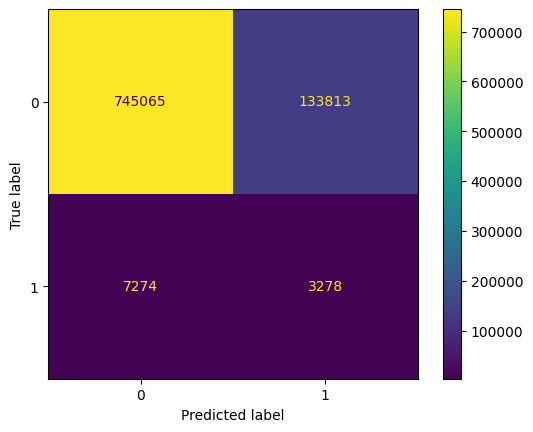

In [ ]:
#Generate confusion matrix for mig 1
labels = np.unique(y_true).tolist()

cm = confusion_matrix(y_true, y_scores, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [83]:
# Final metrics with test set - mig 5
total = df5_test.shape[0]
total_mig = sum(df5_test['MIGRATE5'] == 1)

items = ['LIT', 'NCHILD_2', 'URBAN']
full_items = items + ['MIGRATE5']
TP = np.sum(np.prod([df5_test[col] for col in full_items], axis=0))
total_rule = np.sum(np.prod([df5_test[col] for col in items], axis=0))
FN = total_mig - TP
FP = total_rule - TP
TN = total - TP - FN - FP

print("accruacy", (TP + TN) / (total))
print("precision", (TP / (TP + FP)))
print("recall", (TP / (TP + FN)))
print("f1", (2 * TP) / (2 * TP + FP + FN))

print("MACRO precision", ((TP / (TP + FP)) + (TN / (TN + FN))) / 2)
print("MACRO recall", ((TP / (TP + FN)) + (TN / (TN + FP)) / 2))
print("MACRO f1", ((2 * TP) / (2 * TP + FP + FN) + (2 * TN) / (2 * TN + FP + FN))/2)

accruacy 0.7963711460681385
precision 0.06476826103077493
recall 0.2526979718195759
f1 0.10310897038597983
MACRO precision 0.5112590863498222
MACRO recall 0.6640864457727786
MACRO f1 0.49412829133513037


In [84]:
y_true = df5_test['MIGRATE5']
items = ['LIT', 'NCHILD_2', 'URBAN']
y_scores = np.prod([df5_test[col] for col in items], axis=0)
auc_score = roc_auc_score(y_true, y_scores)
print(auc_score)

0.5377374598629907


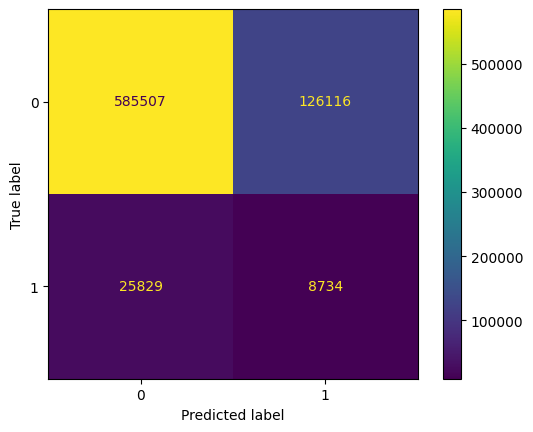

In [85]:
#Generate confusion matrix for mig 5
labels = np.unique(y_true).tolist()

cm = confusion_matrix(y_true, y_scores, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()